In [105]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal, interpolate
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import copernicusmarine
import os, fnmatch

In [110]:
def download_cmems_data(dataset, start_date, end_date, output_directory):
    """
    Downloads CMEMS NetCDF data for the given date range, or uses existing files if available.

    Parameters:
        dataset (str): CMEMS dataset ID.
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.
        output_directory (str): Directory to save downloaded files.

    Returns:
        list: List of file paths for the downloaded or existing NetCDF files.
    """
    current_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    files_append = []

    while current_date <= end_date:
        date_str = current_date.strftime("%Y%m%d")
        filename_pattern = f"*{date_str}_*.nc"

        # Check for files matching the pattern in the output directory
        local_files = [
            os.path.join(output_directory, f)
            for f in os.listdir(output_directory)
            if fnmatch.fnmatch(f, filename_pattern)
        ]
        #print(local_files)
        if not local_files:  # If no matching file exists locally, download it
            get_results = copernicusmarine.get(
                dataset_id=dataset,
                filter=filename_pattern,
                no_directories=True,
                force_download=True,
                output_directory=output_directory
            )
            files_append.extend(get_results)
        else:
            # Append only unique matching files to the list
            files_append.extend(local_files)

        current_date += timedelta(days=1)

    # Ensure the list of files is unique
    files_append = list(set(files_append))

    return files_append


In [111]:
output_directory = "./"
dataset = 'cmems_mod_glo_phy_anfc_merged-uv_PT1H-i'
start_date = "2024-12-01"
end_date = "2024-12-04"

files = download_cmems_data(dataset, start_date, end_date, output_directory)
print(files)

['./SMOC_20241202_R20241203.nc', './SMOC_20241201_R20241202.nc', './SMOC_20241203_R20241204.nc', './SMOC_20241204_R20241204.nc']


In [92]:
# Function to compose CMEMS data into a single DataFrame
def compose_cmems_dataframe(files, lon, lat):
    frames = []
    for file in files:
        ds = xr.open_dataset(file)
        selected = ds.sel(longitude=lon, latitude=lat, method="nearest")
        u = selected["utide"].values.flatten() * 100  # Convert to cm/s
        v = selected["vtide"].values.flatten() * 100  # Convert to cm/s
        timestamps = pd.to_datetime(selected["time"].values)

        frames.append(pd.DataFrame({"timestamp": timestamps, "u": u, "v": v}))
    
    # Combine all frames into one DataFrame
    return pd.concat(frames).reset_index(drop=True)

# Function to fetch data from your API
def fetch_tide_api(lon, lat, start, end, variables=["u", "v"]):
    base_url = "https://eco.odb.ntu.edu.tw/api/tide"
    params = {
        "lon0": lon,
        "lat0": lat,
        "start": start,
        "end": end,
        "append": ",".join(variables)
    }
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    return response.json()

# Function to filter and align timestamps
def compare_and_filter(api_df, cmems_df, cmems_adjusted):
    """
    Filter and align API and CMEMS data for comparison.

    Parameters:
        api_df (pd.DataFrame): API data with columns ["timestamp", "u", "v"].
        cmems_df (pd.DataFrame): Original CMEMS data.
        cmems_adjusted (pd.DataFrame): Adjusted or interpolated CMEMS data.

    Returns:
        pd.DataFrame: Comparison dataframe with aligned timestamps.
    """
    # Ensure timestamps are in UTC
    api_df["timestamp"] = pd.to_datetime(api_df["timestamp"]).dt.tz_convert("UTC")
    cmems_adjusted["timestamp"] = pd.to_datetime(cmems_adjusted["timestamp"]).dt.tz_convert("UTC")

    # Determine the overlapping time range
    min_time = max(api_df["timestamp"].min(), cmems_adjusted["timestamp"].min())
    max_time = min(api_df["timestamp"].max(), cmems_adjusted["timestamp"].max())

    # Filter API and CMEMS data within the overlapping time range
    api_filtered = api_df[(api_df["timestamp"] >= min_time) & (api_df["timestamp"] <= max_time)]
    cmems_filtered = cmems_adjusted[(cmems_adjusted["timestamp"] >= min_time) & (cmems_adjusted["timestamp"] <= max_time)]

    # Prepare comparison dataframe
    comparison_df = pd.DataFrame({
        "timestamp": api_filtered["timestamp"],
        "u_api": api_filtered["u"],
        "v_api": api_filtered["v"],
        "u_cmems": cmems_filtered["u"].values,
        "v_cmems": cmems_filtered["v"].values
    })
    return comparison_df


# Calculate phase difference
def calculate_phase_difference(signal1, signal2):
    correlation = signal.correlate(signal1 - np.mean(signal1), signal2 - np.mean(signal2), mode='full')
    lags = signal.correlation_lags(len(signal1), len(signal2), mode='full')
    lag = lags[np.argmax(correlation)]
    return lag

# Plot statistics
def plot_statistics(comparison_df):
    plt.figure(figsize=(12, 8))
    
    # Plot U-component differences
    plt.subplot(2, 1, 1)
    plt.plot(comparison_df["timestamp"], comparison_df["u_api"], label="API u")
    plt.plot(comparison_df["timestamp"], comparison_df["u_cmems"], label="CMEMS u")
    plt.fill_between(comparison_df["timestamp"], comparison_df["u_api"], comparison_df["u_cmems"], alpha=0.2)
    plt.title("Comparison of U-Component (Tidal Current)")
    plt.xlabel("Time")
    plt.ylabel("U-Component (cm/s)")
    plt.legend()
    
    # Plot V-component differences
    plt.subplot(2, 1, 2)
    plt.plot(comparison_df["timestamp"], comparison_df["v_api"], label="API v")
    plt.plot(comparison_df["timestamp"], comparison_df["v_cmems"], label="CMEMS v")
    plt.fill_between(comparison_df["timestamp"], comparison_df["v_api"], comparison_df["v_cmems"], alpha=0.2)
    plt.title("Comparison of V-Component (Tidal Current)")
    plt.xlabel("Time")
    plt.ylabel("V-Component (cm/s)")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [159]:
lon, lat = 124.781, 33.475
cmems_df = compose_cmems_dataframe(files, lon, lat)


In [160]:
print(cmems_df[0:50 :])

             timestamp          u          v
0  2024-12-02 00:30:00 -31.347656 -13.769531
1  2024-12-02 01:30:00 -39.843750  16.406250
2  2024-12-02 02:30:00 -37.890625  42.578125
3  2024-12-02 03:30:00 -27.246094  58.300781
4  2024-12-02 04:30:00 -11.230469  60.449219
5  2024-12-02 05:30:00   6.152344  49.609375
6  2024-12-02 06:30:00  20.117188  29.003906
7  2024-12-02 07:30:00  26.855469   4.589844
8  2024-12-02 08:30:00  25.878906 -16.796875
9  2024-12-02 09:30:00  18.847656 -29.980469
10 2024-12-02 10:30:00   7.128906 -32.714844
11 2024-12-02 11:30:00  -8.007812 -25.195312
12 2024-12-02 12:30:00 -22.363281  -9.082031
13 2024-12-02 13:30:00 -30.078125  11.230469
14 2024-12-02 14:30:00 -27.734375  29.296875
15 2024-12-02 15:30:00 -16.601562  38.867188
16 2024-12-02 16:30:00  -0.292969  36.425781
17 2024-12-02 17:30:00  17.480469  21.875000
18 2024-12-02 18:30:00  32.128906  -1.464844
19 2024-12-02 19:30:00  39.648438 -27.929688
20 2024-12-02 20:30:00  38.378906 -50.781250
21 2024-12

In [ ]:
start = "2024-11-30T23:00:00Z" #slightly earlier than start_date
end = "2024-12-05T00:00:00Z" #slightly later than end_date

# Fetch data from API
api_data = fetch_tide_api(lon, lat, start, end, variables=["u", "v"])
api_df = pd.DataFrame({
    "timestamp": pd.to_datetime(api_data["time"]),
    "u": api_data["u"],
    "v": api_data["v"]
})

In [162]:
print(api_df[0:50])

                   timestamp          u          v
0  2024-11-30 23:00:00+00:00 -23.018836 -33.016175
1  2024-12-01 00:00:00+00:00 -35.788406  -5.791236
2  2024-12-01 01:00:00+00:00 -40.050868  22.976430
3  2024-12-01 02:00:00+00:00 -34.294357  47.005758
4  2024-12-01 03:00:00+00:00 -20.170739  60.850333
5  2024-12-01 04:00:00+00:00  -2.099237  61.442630
6  2024-12-01 05:00:00+00:00  14.490559  49.159462
7  2024-12-01 06:00:00+00:00  25.240633  27.827267
8  2024-12-01 07:00:00+00:00  28.084706   3.527164
9  2024-12-01 08:00:00+00:00  23.193365 -17.325019
10 2024-12-01 09:00:00+00:00  12.208630 -29.807042
11 2024-12-01 10:00:00+00:00  -2.354489 -31.582333
12 2024-12-01 11:00:00+00:00 -17.221238 -23.118972
13 2024-12-01 12:00:00+00:00 -28.468000  -7.312384
14 2024-12-01 13:00:00+00:00 -32.308757  11.180785
15 2024-12-01 14:00:00+00:00 -26.586157  26.839844
16 2024-12-01 15:00:00+00:00 -12.117337  34.511433
17 2024-12-01 16:00:00+00:00   7.177657  30.896385
18 2024-12-01 17:00:00+00:00  2

In [96]:
def adjust_cmems_timestamps(cmems_df, api_df, adjustment="interpolate", scale=1.0):
    """
    Adjust CMEMS timestamps for comparison with API data.

    Parameters:
        cmems_df (pd.DataFrame): CMEMS data with columns ["timestamp", "u", "v"].
        api_df (pd.DataFrame): API data with columns ["timestamp", "u", "v"].
        adjustment (str): Method to adjust CMEMS timestamps. Options:
                          "interpolate" - Interpolate CMEMS data to match API timestamps.
                          "delay+1"     - Shift CMEMS timestamps by +1 hour.
                          "delay-1"     - Shift CMEMS timestamps by -1 hour.

    Returns:
        pd.DataFrame: Adjusted CMEMS data with aligned timestamps.
    """
    api_filtered = api_df.copy()
    cmems_filtered = cmems_df.copy()

    # Ensure both timestamps are UTC
    api_filtered["timestamp"] = pd.to_datetime(api_filtered["timestamp"]).dt.tz_convert("UTC")
    cmems_filtered["timestamp"] = pd.to_datetime(cmems_filtered["timestamp"]).dt.tz_localize("UTC")

    if adjustment == "delay+1":
        # Shift CMEMS timestamps forward by 1 hour
        cmems_filtered["timestamp"] += pd.Timedelta(hours=0.5)
        cmems_filtered["u"] *= scale  # Convert m/s to cm/s
        cmems_filtered["v"] *= scale  # Convert m/s to cm/s
    elif adjustment == "delay-1":
        # Shift CMEMS timestamps backward by 1 hour
        cmems_filtered["timestamp"] -= pd.Timedelta(hours=0.5)
        cmems_filtered["u"] *= scale  # Convert m/s to cm/s
        cmems_filtered["v"] *= scale  # Convert m/s to cm/s
    elif adjustment == "interpolate":
        # Convert timestamps to numeric values for interpolation
        cmems_times = cmems_filtered["timestamp"].astype(np.int64) // 10**9
        api_times = api_filtered["timestamp"].astype(np.int64) // 10**9

        # Create interpolation functions for u and v
        u_interp = interpolate.interp1d(
            cmems_times,
            cmems_filtered["u"]  * scale,  # Convert m/s to cm/s
            kind="linear",
            fill_value="extrapolate"
        )
        v_interp = interpolate.interp1d(
            cmems_times,
            cmems_filtered["v"]  * scale,  # Convert m/s to cm/s
            kind="linear",
            fill_value="extrapolate"
        )

        # Interpolate CMEMS data to match API timestamps
        return pd.DataFrame({
            "timestamp": api_filtered["timestamp"],
            "u": u_interp(api_filtered["timestamp"].astype(np.int64) // 10**9),
            "v": v_interp(api_filtered["timestamp"].astype(np.int64) // 10**9)
        })

    # Align timestamps for delay adjustments
    cmems_filtered = cmems_filtered.set_index("timestamp")
    cmems_adjusted = (
        cmems_filtered.reindex(api_filtered["timestamp"])
        .reset_index()
    )
    return cmems_adjusted

In [163]:
cmems_interpolated = adjust_cmems_timestamps(cmems_df, api_df, adjustment="interpolate", scale=1.0)
print(cmems_interpolated)

                   timestamp          u          v
0  2024-11-30 23:00:00+00:00 -33.007812 -37.890625
1  2024-12-01 00:00:00+00:00 -35.351562 -10.156250
2  2024-12-01 01:00:00+00:00 -37.695312  17.578125
3  2024-12-01 02:00:00+00:00 -35.400391  41.406250
4  2024-12-01 03:00:00+00:00 -25.000000  55.273438
..                       ...        ...        ...
93 2024-12-04 20:00:00+00:00  31.103516  -8.837891
94 2024-12-04 21:00:00+00:00  36.132812 -32.421875
95 2024-12-04 22:00:00+00:00  33.447266 -51.269531
96 2024-12-04 23:00:00+00:00  24.267578 -60.595703
97 2024-12-05 00:00:00+00:00  12.451172 -64.208984

[98 rows x 3 columns]


In [165]:
comparison_df = compare_and_filter(api_df, cmems_df, cmems_interpolated)

print(comparison_df[0:50])

                   timestamp      u_api      v_api    u_cmems    v_cmems
0  2024-11-30 23:00:00+00:00 -23.018836 -33.016175 -33.007812 -37.890625
1  2024-12-01 00:00:00+00:00 -35.788406  -5.791236 -35.351562 -10.156250
2  2024-12-01 01:00:00+00:00 -40.050868  22.976430 -37.695312  17.578125
3  2024-12-01 02:00:00+00:00 -34.294357  47.005758 -35.400391  41.406250
4  2024-12-01 03:00:00+00:00 -20.170739  60.850333 -25.000000  55.273438
5  2024-12-01 04:00:00+00:00  -2.099237  61.442630  -9.375000  56.445312
6  2024-12-01 05:00:00+00:00  14.490559  49.159462   7.275391  45.361328
7  2024-12-01 06:00:00+00:00  25.240633  27.827267  20.214844  25.390625
8  2024-12-01 07:00:00+00:00  28.084706   3.527164  26.269531   2.197266
9  2024-12-01 08:00:00+00:00  23.193365 -17.325019  25.146484 -17.773438
10 2024-12-01 09:00:00+00:00  12.208630 -29.807042  18.066406 -29.833984
11 2024-12-01 10:00:00+00:00  -2.354489 -31.582333   6.005859 -31.933594
12 2024-12-01 11:00:00+00:00 -17.221238 -23.118972 

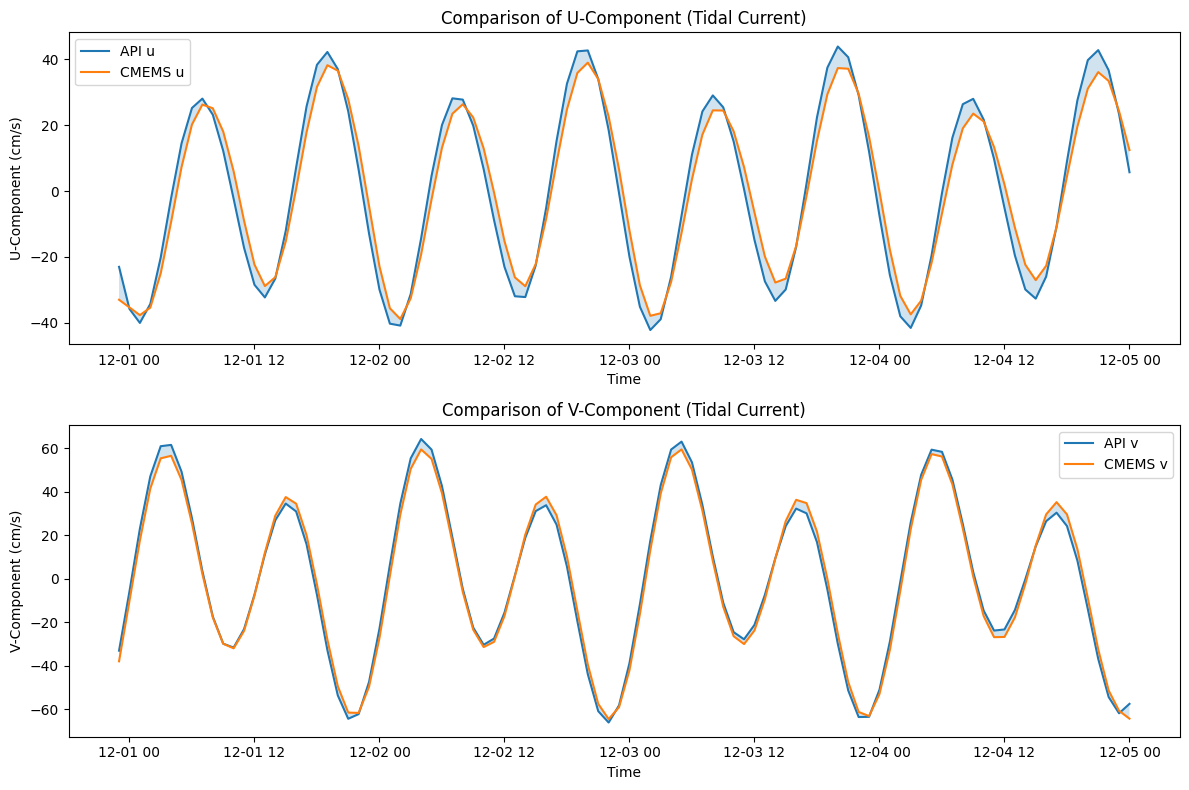

In [166]:
# Plot results
plot_statistics(comparison_df)

In [129]:
# Old code from simu_target_tideapi01.ipynb
# Calculate phase difference using cross-correlation
def calculate_phase_difference(signal1, signal2):
    """
    Calculate phase difference between two signals using cross-correlation.
    
    Parameters:
        signal1 (array-like): First signal.
        signal2 (array-like): Second signal.
    
    Returns:
        float: Phase difference in hours.
    """
    correlation = signal.correlate(signal1 - np.mean(signal1), signal2 - np.mean(signal2), mode='full')
    lags = signal.correlation_lags(len(signal1), len(signal2), mode='full')
    lag = lags[np.argmax(correlation)]
    return lag  # Lag is in number of samples


def two_tides_compare(comparison_df, phase_diff_hours_u, phase_diff_hours_v, target_name="CMEMS"):
    """
    Plot comparisons between two tidal datasets for u and v components.
    
    Parameters:
        comparison_df (pd.DataFrame): DataFrame with timestamps, u, and v components for both datasets.
        phase_diff_hours_u (float): Phase difference in hours for the u-component.
        phase_diff_hours_v (float): Phase difference in hours for the v-component.
        target_name (str): Name of the comparison dataset (e.g., "CMEMS").
    """
    plt.figure(figsize=(14, 10))

    # U-component comparison
    plt.subplot(2, 1, 1)
    plt.plot(comparison_df["timestamp"], comparison_df["u_api"], label="API u")
    plt.plot(comparison_df["timestamp"], comparison_df["u_cmems"], label=f"{target_name} u")
    plt.fill_between(comparison_df["timestamp"], comparison_df["u_api"] - comparison_df["u_cmems"],
                     comparison_df["u_api"] + comparison_df["u_cmems"], alpha=0.2)
    plt.xlabel("Time")
    plt.ylabel("U-Component (cm/s)")
    plt.legend()
    plt.title(f"Comparison of U-Component (Tidal Current)\nPhase Difference: {phase_diff_hours_u:.2f} hours")

    # V-component comparison
    plt.subplot(2, 1, 2)
    plt.plot(comparison_df["timestamp"], comparison_df["v_api"], label="API v")
    plt.plot(comparison_df["timestamp"], comparison_df["v_cmems"], label=f"{target_name} v")
    plt.fill_between(comparison_df["timestamp"], comparison_df["v_api"] - comparison_df["v_cmems"],
                     comparison_df["v_api"] + comparison_df["v_cmems"], alpha=0.2)
    plt.xlabel("Time")
    plt.ylabel("V-Component (cm/s)")
    plt.legend()
    plt.title(f"Comparison of V-Component (Tidal Current)\nPhase Difference: {phase_diff_hours_v:.2f} hours")

    plt.tight_layout()
    plt.show()



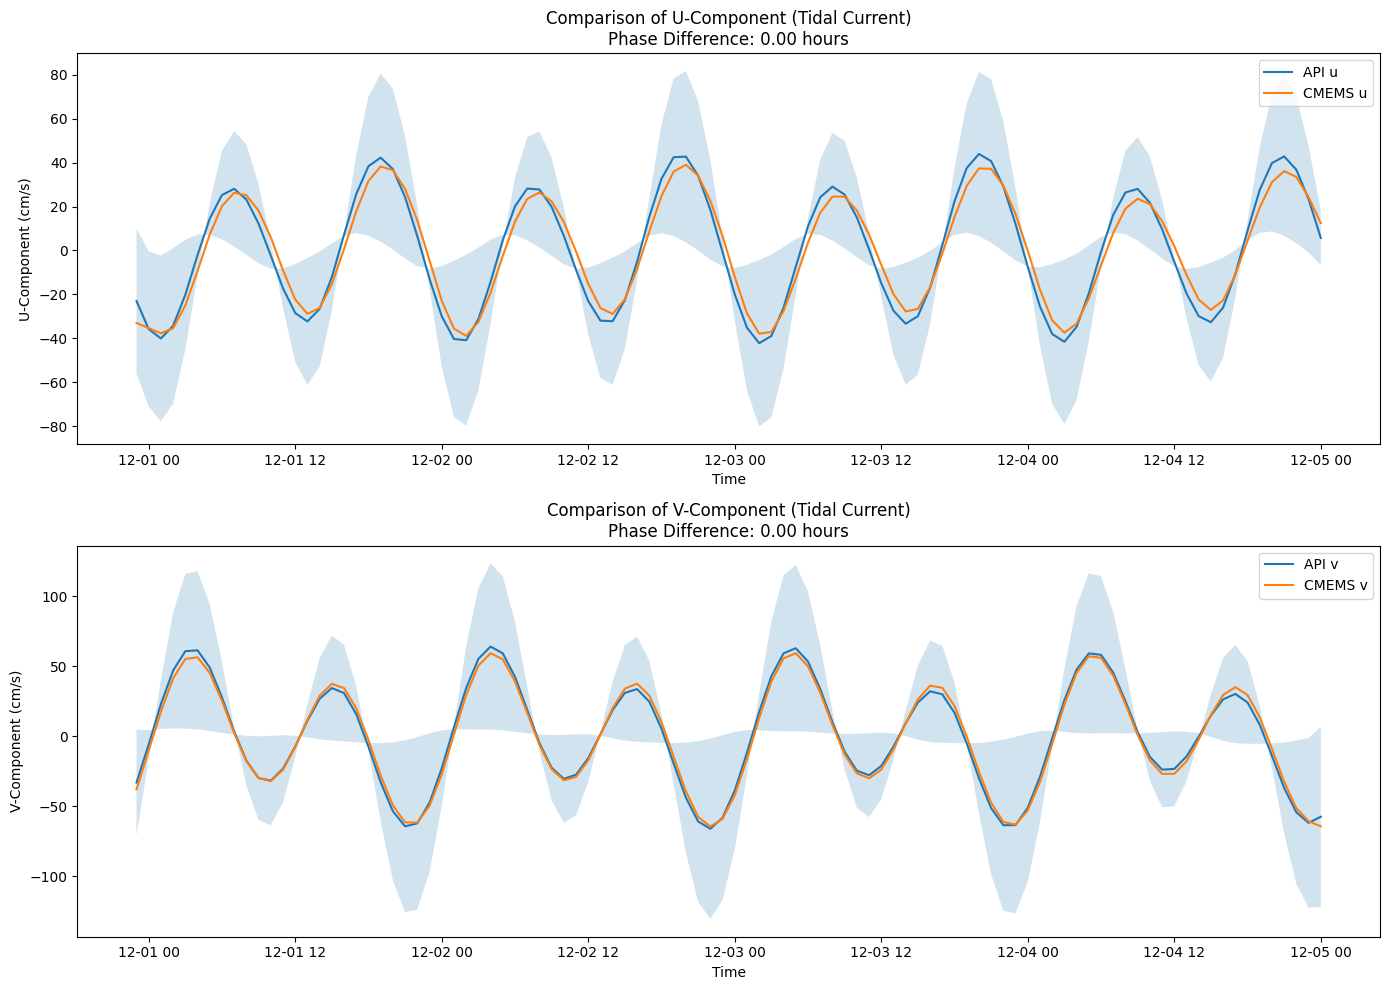

In [167]:
# Calculate phase differences
phase_diff_u = calculate_phase_difference(comparison_df["u_api"].values, comparison_df["u_cmems"].values)
phase_diff_v = calculate_phase_difference(comparison_df["v_api"].values, comparison_df["v_cmems"].values)

# Convert lag to hours
phase_diff_hours_u = phase_diff_u / 60  # Assuming 1 sample = 1 minute
phase_diff_hours_v = phase_diff_v / 60  # Assuming 1 sample = 1 minute

# Plot comparisons
two_tides_compare(comparison_df, phase_diff_hours_u, phase_diff_hours_v, target_name="CMEMS")


In [137]:
def compare_tide_api_cmems(lon, lat, start, end, cmems_dir='./', method='interpolate', dataset='cmems_mod_glo_phy_anfc_merged-uv_PT1H-i'):
    """
    Compare tidal current data from the Tide API and CMEMS datasets.

    Parameters:
        lon (float): Longitude of the location.
        lat (float): Latitude of the location.
        start (str): Start date in "YYYY-MM-DD" format.
        end (str): End date in "YYYY-MM-DD" format.
        cmems_dir (str): Directory for CMEMS files.
        method (str): Adjustment method for CMEMS timestamps: 'interpolate', 'delay+1', or 'delay-1'.
        dataset (str): CMEMS dataset ID.

    Returns:
        None. The function plots the comparison results.
    """
    try:
        # Step 1: Download and compose CMEMS data
        print(f"Downloading CMEMS data from {start} to {end}...")
        cmems_files = download_cmems_data(dataset, start, end, cmems_dir)
        cmems_df = compose_cmems_dataframe(cmems_files, lon, lat)
        
        # Step 2: Adjust API fetch time to start earlier and end later
        api_start = (pd.to_datetime(start) - pd.Timedelta(hours=1)).strftime("%Y-%m-%dT%H:%M:%SZ")
        api_end = (pd.to_datetime(end) + pd.Timedelta(hours=1)).strftime("%Y-%m-%dT%H:%M:%SZ")
        
        print(f"Fetching Tide API data from {api_start} to {api_end}...")
        api_data = fetch_tide_api(lon, lat, api_start, api_end, variables=["u", "v"])
        
        # Step 3: Create API DataFrame
        api_df = pd.DataFrame({
            "timestamp": pd.to_datetime(api_data["time"]),
            "u": api_data["u"],
            "v": api_data["v"]
        })
        
        # Step 4: Adjust CMEMS timestamps and interpolate (if needed)
        print(f"Adjusting CMEMS timestamps using method: {method}...")
        cmems_interpolated = adjust_cmems_timestamps(cmems_df, api_df, adjustment=method, scale=1.0)  # Convert m/s to cm/s
        
        # Step 5: Compare and filter overlapping time ranges
        print("Filtering and aligning overlapping time ranges...")
        comparison_df = compare_and_filter(api_df, cmems_df, cmems_interpolated)
        
        if comparison_df.empty:
            raise ValueError("No overlapping data found after filtering. Check the date ranges and data availability.")
        
        # Step 6: Calculate phase differences
        print("Calculating phase differences...")
        phase_diff_u = calculate_phase_difference(comparison_df["u_api"].values, comparison_df["u_cmems"].values)
        phase_diff_v = calculate_phase_difference(comparison_df["v_api"].values, comparison_df["v_cmems"].values)
        
        # Convert lag to hours
        phase_diff_hours_u = phase_diff_u / 60  # Assuming 1 sample = 1 minute
        phase_diff_hours_v = phase_diff_v / 60  # Assuming 1 sample = 1 minute
        
        # Step 7: Plot comparisons
        print("Plotting comparison results...")
        two_tides_compare(comparison_df, phase_diff_hours_u, phase_diff_hours_v, target_name="CMEMS")
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise


Fetching Tide API data from 2024-11-30T23:00:00Z to 2024-12-04T01:00:00Z...
Adjusting CMEMS timestamps using method: interpolate...
Filtering and aligning overlapping time ranges...
Calculating phase differences...
Plotting comparison results...


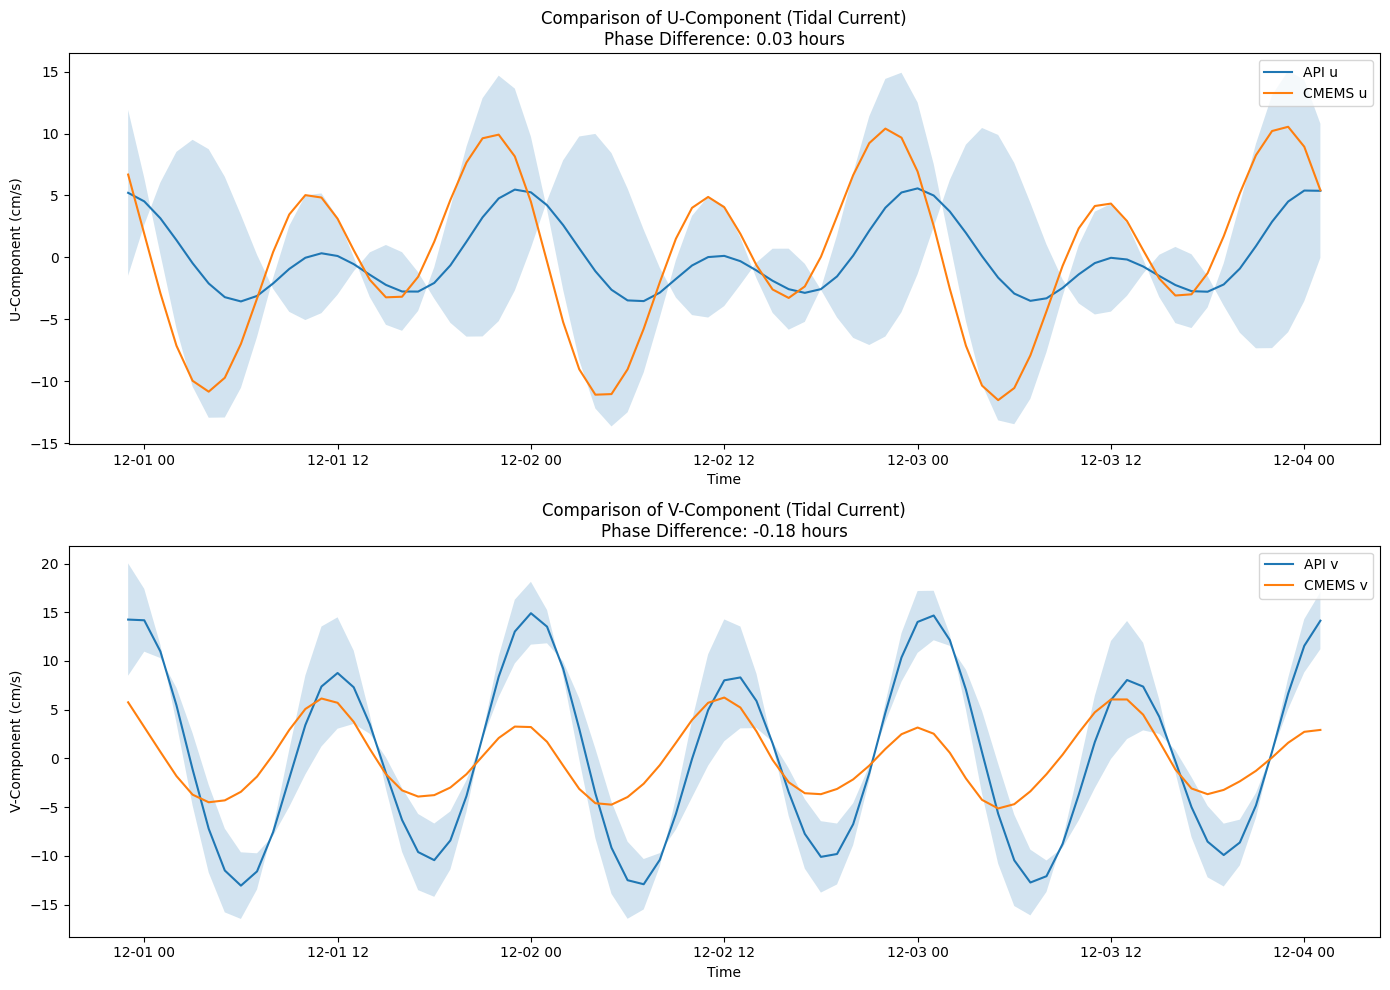

In [158]:
compare_tide_api_cmems(
    lon=122.1,
    lat=24.815,
    start="2024-12-01",
    end="2024-12-04",
    cmems_dir="./",
    method="interpolate"
)

Fetching Tide API data from 2024-11-30T23:00:00Z to 2024-12-04T01:00:00Z...
Adjusting CMEMS timestamps using method: interpolate...
Filtering and aligning overlapping time ranges...
Calculating phase differences...
Plotting comparison results...


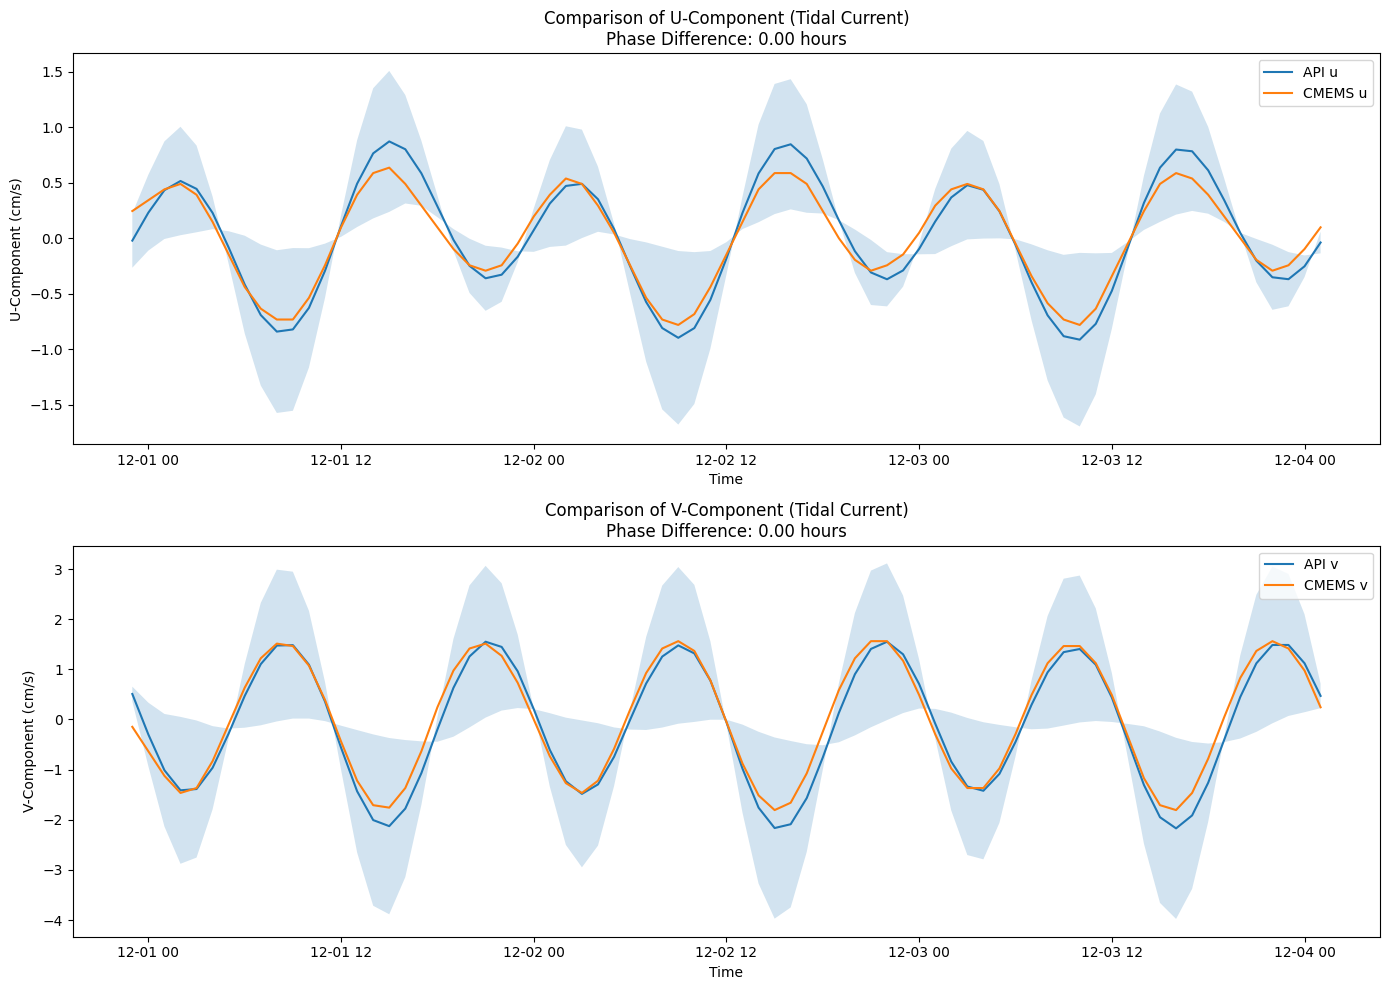

In [141]:
compare_tide_api_cmems(
    lon=-54.80,
    lat=44.65,
    start="2024-12-01",
    end="2024-12-04",
    cmems_dir="./",
    method="interpolate"
)

Fetching Tide API data from 2024-11-30T23:00:00Z to 2024-12-04T01:00:00Z...
Adjusting CMEMS timestamps using method: interpolate...
Filtering and aligning overlapping time ranges...
Calculating phase differences...
Plotting comparison results...


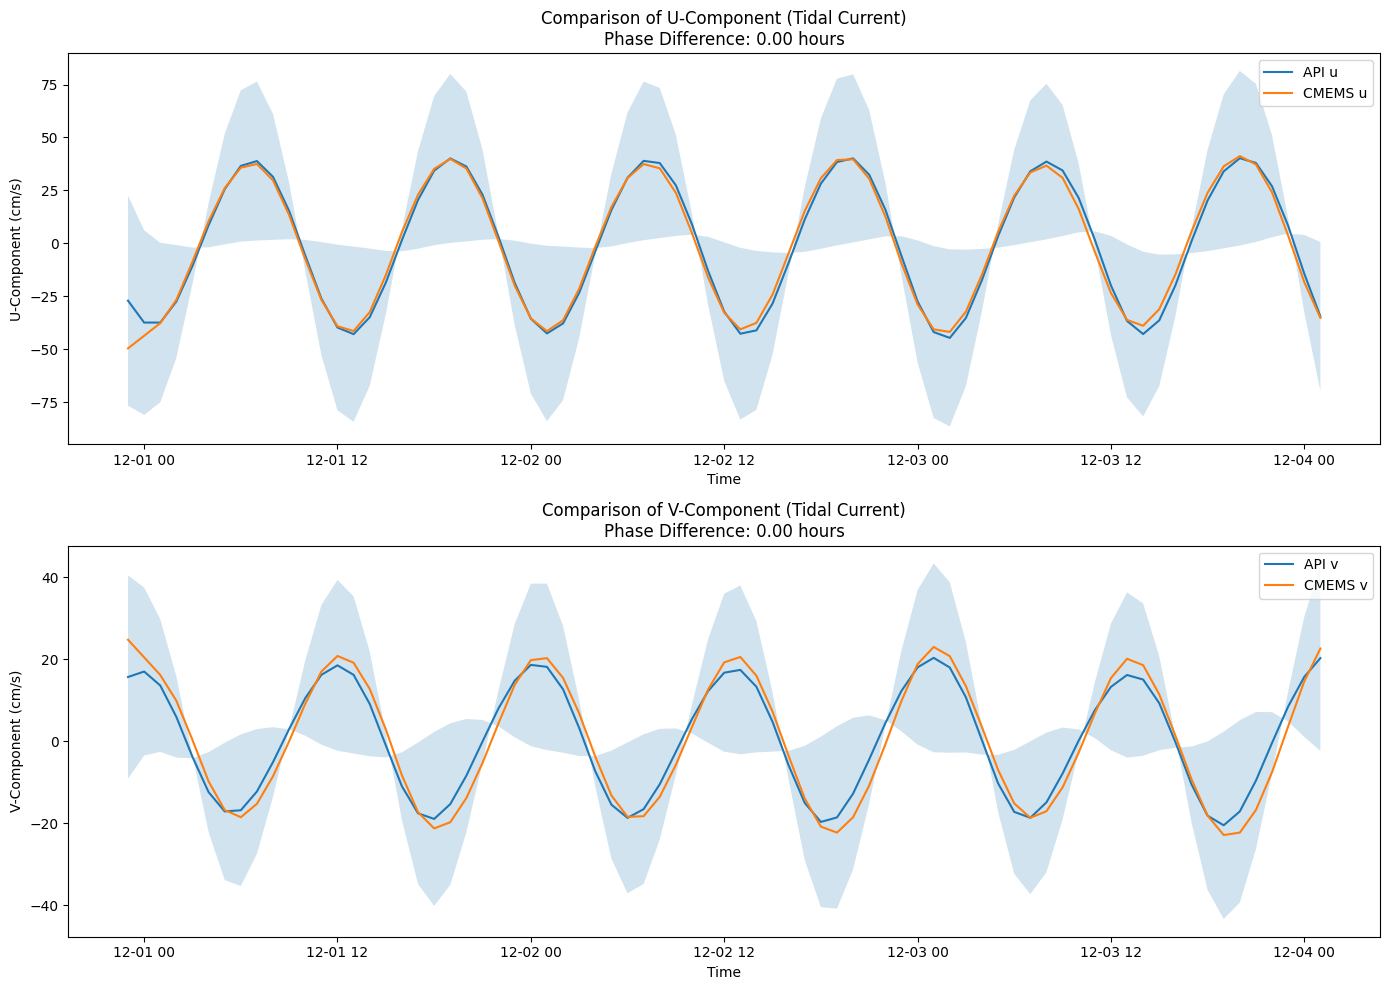

In [142]:
compare_tide_api_cmems(
    lon=2,
    lat=54,
    start="2024-12-01",
    end="2024-12-04",
    cmems_dir="./",
    method="interpolate"
)


Fetching Tide API data from 2024-11-30T23:00:00Z to 2024-12-04T01:00:00Z...
Adjusting CMEMS timestamps using method: interpolate...
Filtering and aligning overlapping time ranges...
Calculating phase differences...
Plotting comparison results...


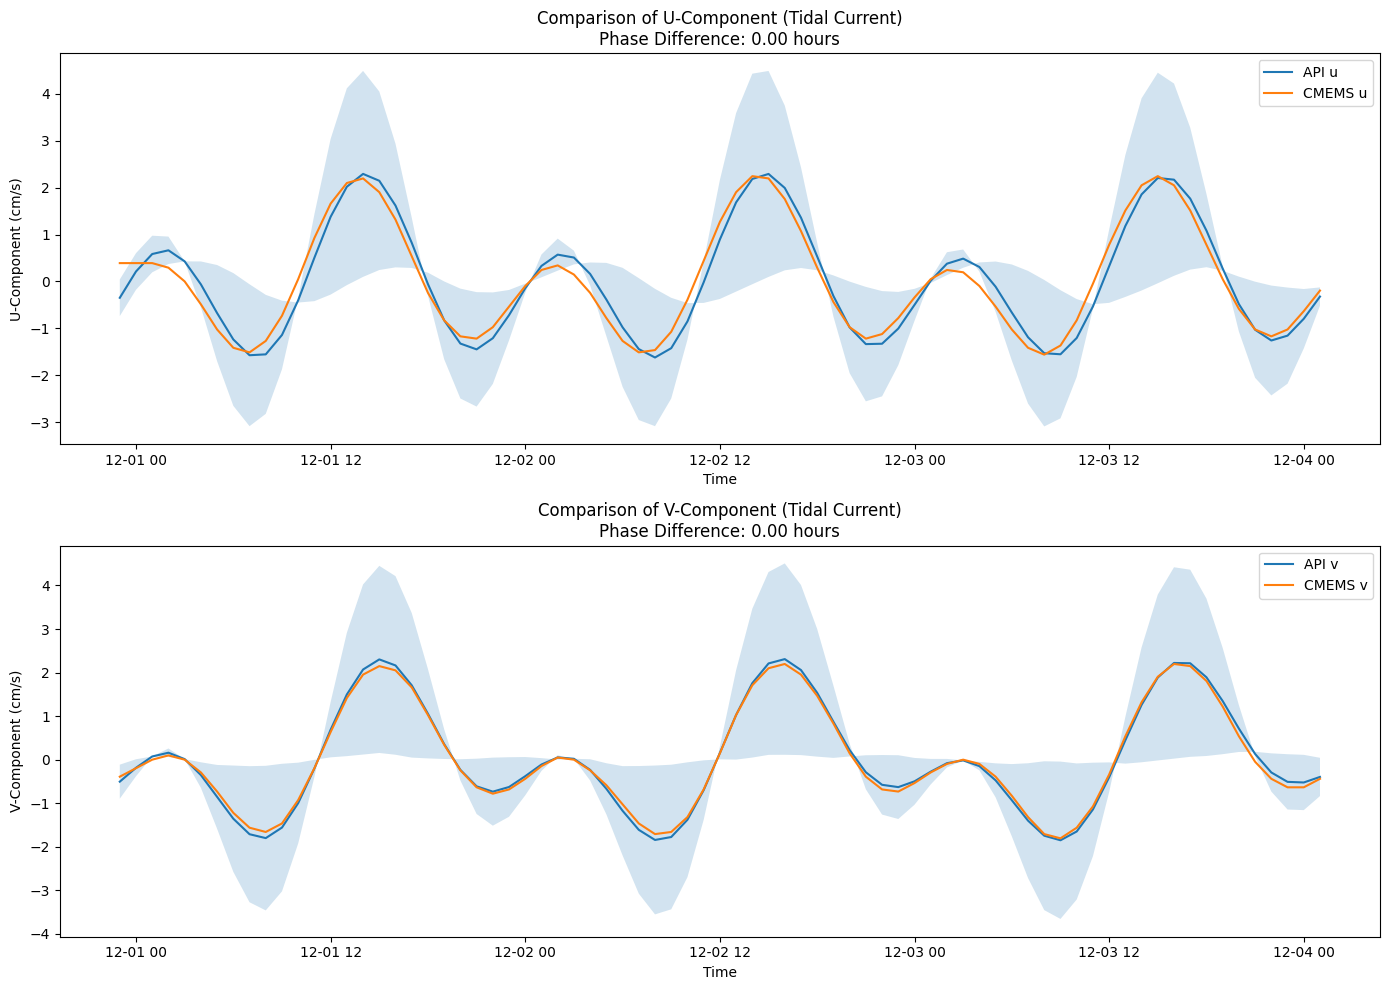

In [143]:
compare_tide_api_cmems(
    lon=132.324,
    lat=31.31,
    start="2024-12-01",
    end="2024-12-04",
    cmems_dir="./",
    method="interpolate"
)

Fetching Tide API data from 2024-11-30T23:00:00Z to 2024-12-04T01:00:00Z...
Adjusting CMEMS timestamps using method: interpolate...
Filtering and aligning overlapping time ranges...
Calculating phase differences...
Plotting comparison results...


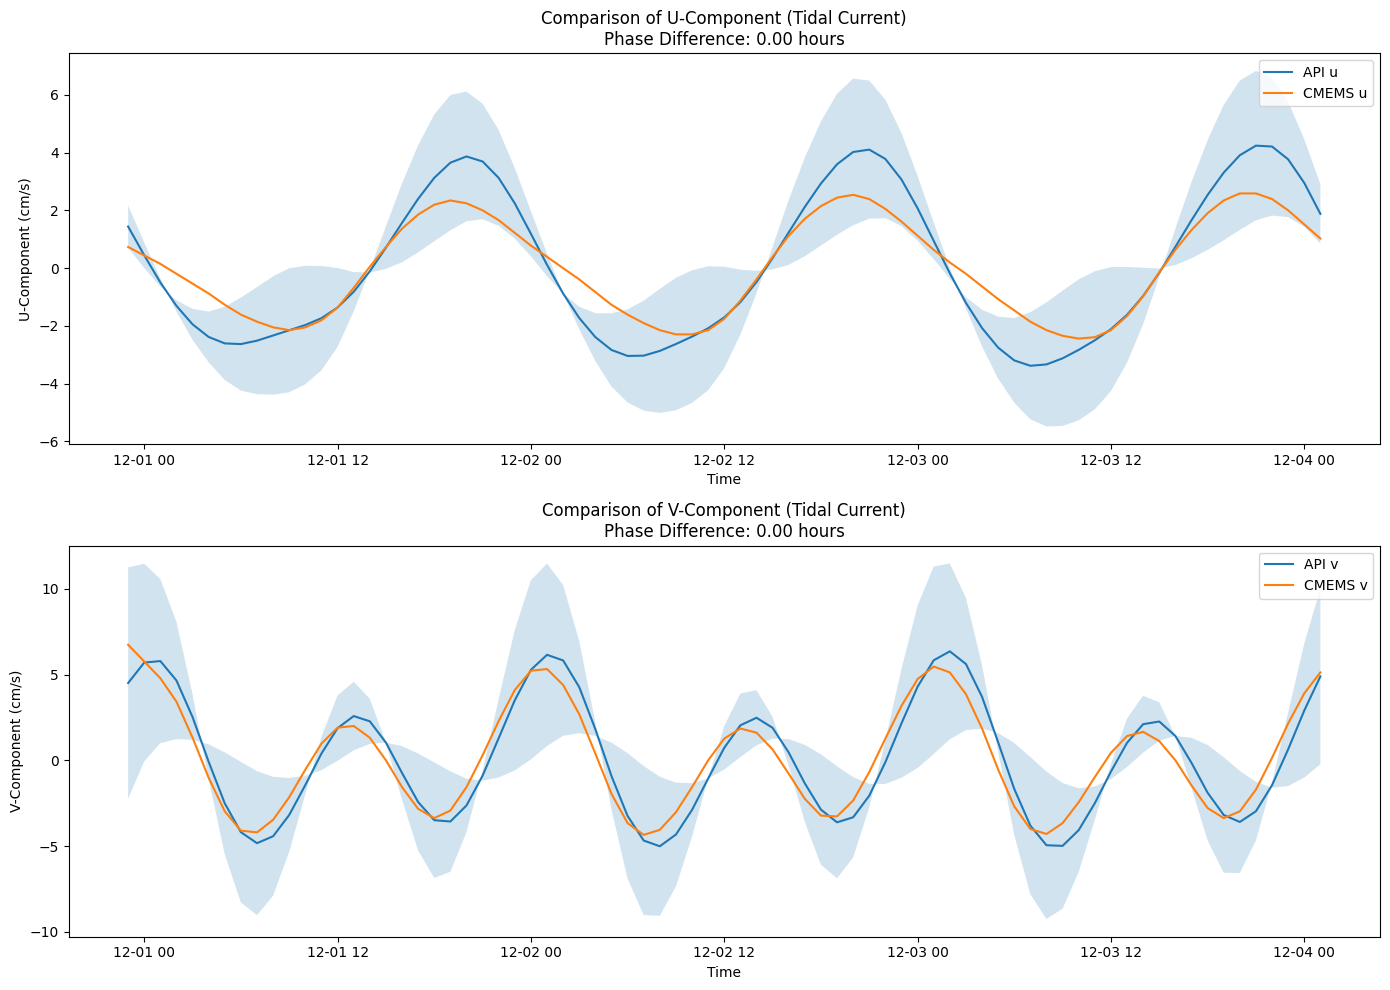

In [145]:
compare_tide_api_cmems(
    lon=119.53,
    lat=22.3,
    start="2024-12-01",
    end="2024-12-04",
    cmems_dir="./",
    method="interpolate"
)

Fetching Tide API data from 2024-11-30T23:00:00Z to 2024-12-04T01:00:00Z...
Adjusting CMEMS timestamps using method: interpolate...
Filtering and aligning overlapping time ranges...
Calculating phase differences...
Plotting comparison results...


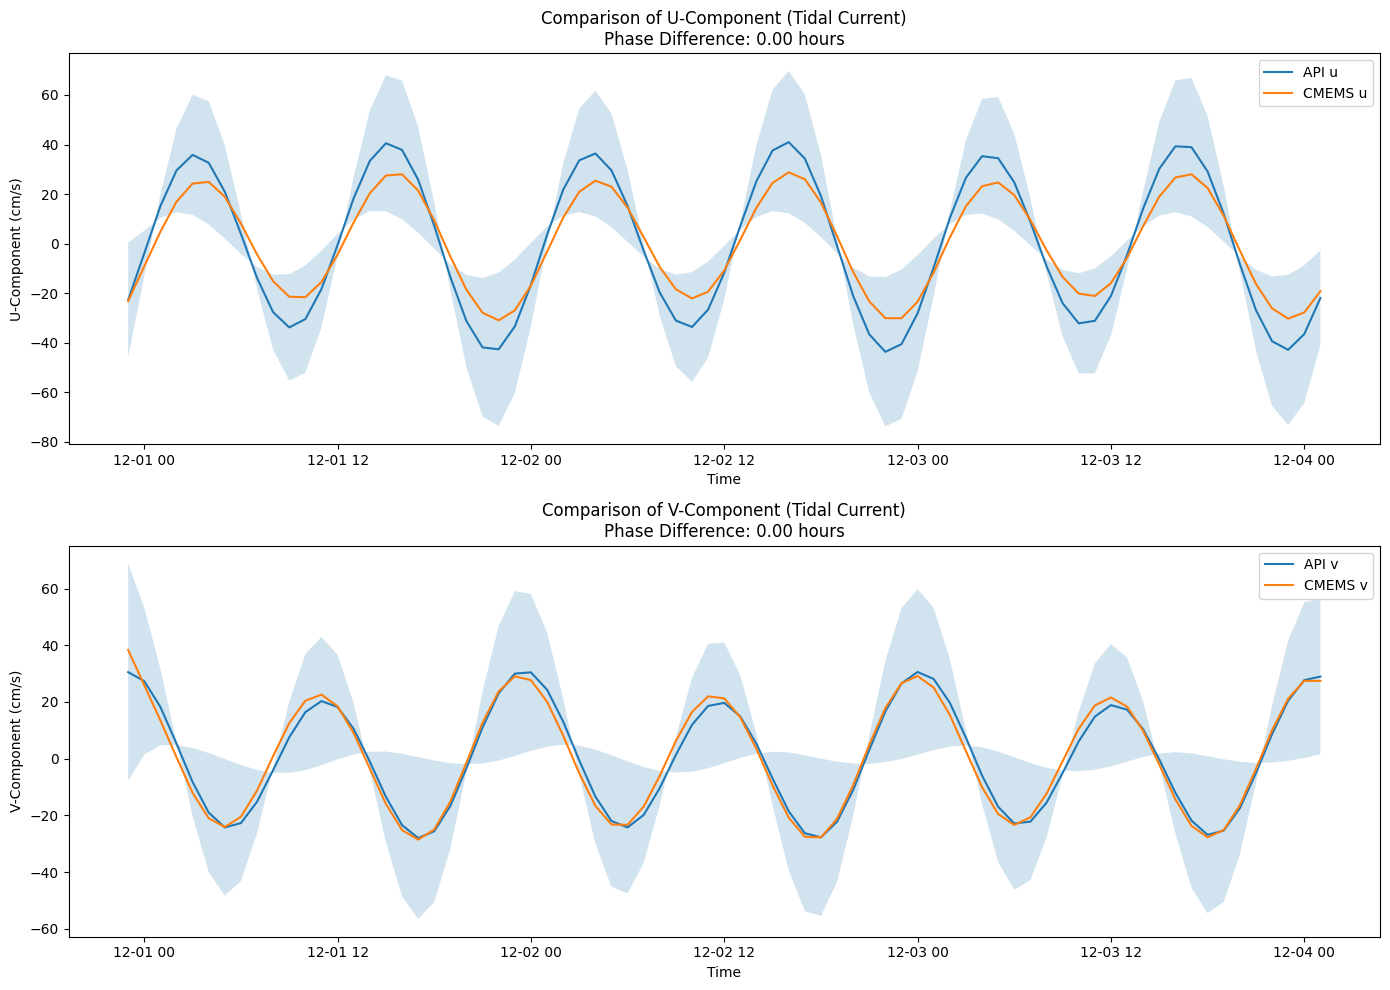

In [147]:
compare_tide_api_cmems(
    lon=124.215,
    lat=27.44,
    start="2024-12-01",
    end="2024-12-04",
    cmems_dir="./",
    method="interpolate"
)

Fetching Tide API data from 2024-11-30T23:00:00Z to 2024-12-04T01:00:00Z...
Adjusting CMEMS timestamps using method: interpolate...
Filtering and aligning overlapping time ranges...
Calculating phase differences...
Plotting comparison results...


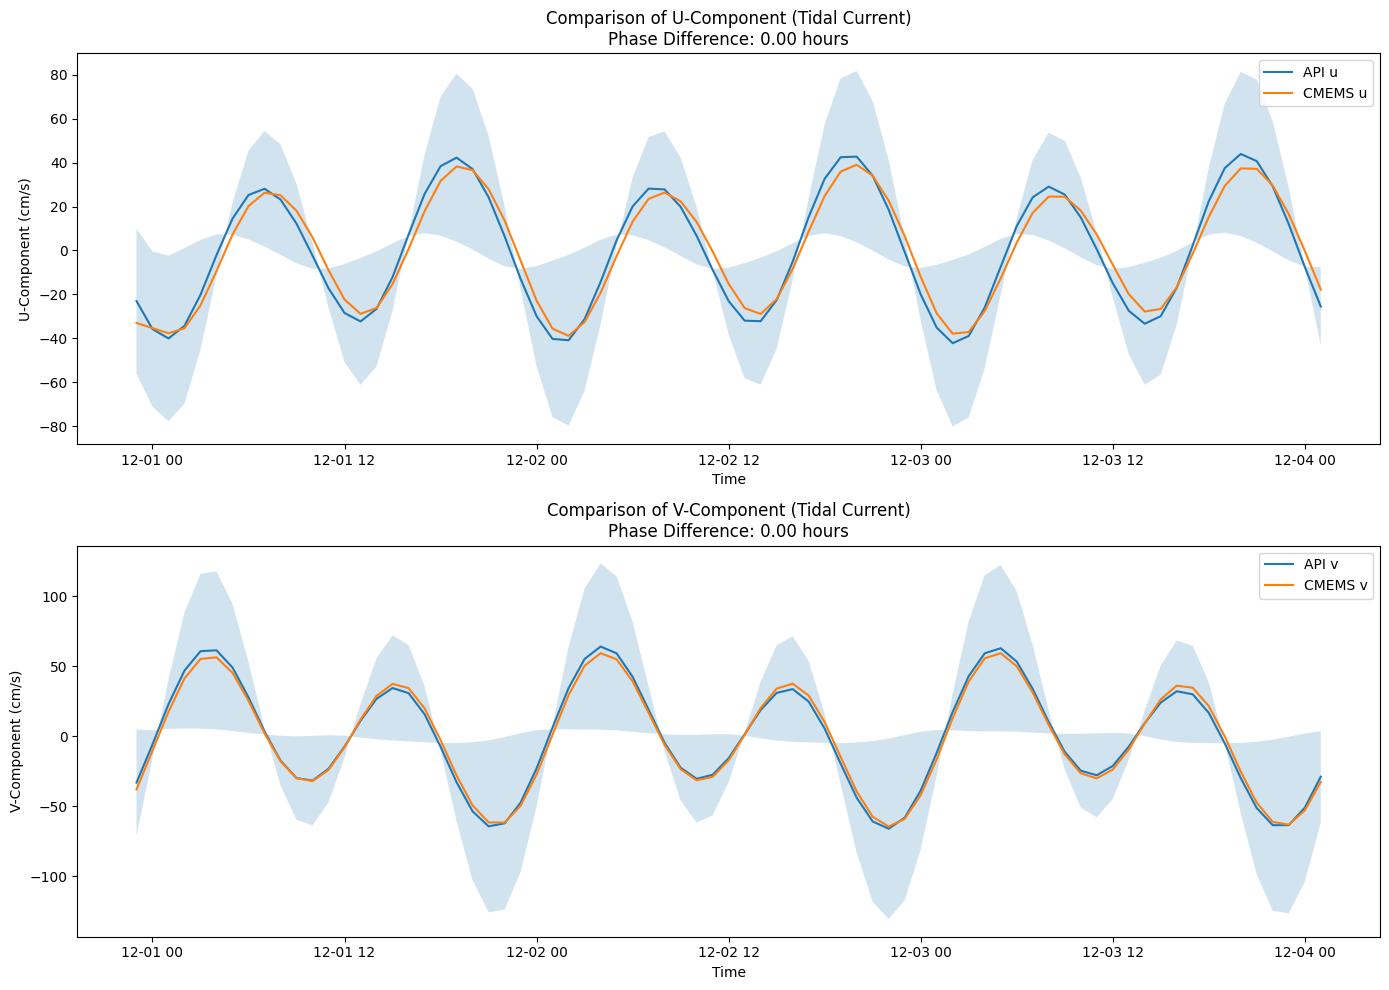

In [155]:
compare_tide_api_cmems(
    lon=124.781,
    lat=33.475,
    start="2024-12-01",
    end="2024-12-04",
    cmems_dir="./",
    method="interpolate"
)

In [ ]:
#Other test （Read files)
# Fetch CMEMS data
ds = xr.open_dataset("./SMOC_20241201_R20241202.nc")
print(ds)

<xarray.Dataset> Size: 7GB
Dimensions:    (longitude: 4320, latitude: 2041, depth: 1, time: 24)
Coordinates:
  * longitude  (longitude) float32 17kB -180.0 -179.9 -179.8 ... 179.8 179.9
  * latitude   (latitude) float32 8kB -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * depth      (depth) float32 4B 0.494
  * time       (time) datetime64[ns] 192B 2024-12-01T00:30:00 ... 2024-12-01T...
Data variables:
    utotal     (time, depth, latitude, longitude) float32 846MB ...
    vtotal     (time, depth, latitude, longitude) float32 846MB ...
    utide      (time, depth, latitude, longitude) float32 846MB ...
    vtide      (time, depth, latitude, longitude) float32 846MB ...
    uo         (time, depth, latitude, longitude) float32 846MB ...
    vo         (time, depth, latitude, longitude) float32 846MB ...
    vsdx       (time, depth, latitude, longitude) float32 846MB ...
    vsdy       (time, depth, latitude, longitude) float32 846MB ...
Attributes:
    producer:                      CMEMS -